In [39]:
import os
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import resample

from keras.regularizers import l2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Lambda, Input, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.backend import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from utils.utils import oversample_category, visualize_images, get_image_paths

In [40]:
# Define dataset directory
data_dir = './Dataset_BUSI_with_GT_copy/'

# List of subdirectories (categories)
categories = ['benign', 'malignant', 'normal']

In [41]:
# Count the number of images in each category and display
categories_size = []
for category in categories:
    path = os.path.join(data_dir, category)
    images = os.listdir(path)
    categories_size.append(len(images))
    print(f"Number of {category} images:", len(images))

Number of benign images: 4
Number of malignant images: 4
Number of normal images: 4


In [116]:
# Define the split ratios
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Ensure the structure is created and split the files
for class_name in categories:
    # Source directory for the class
    src_directory = os.path.join(data_dir, class_name)

    # Get all file names for this class
    all_files = os.listdir(src_directory)
    all_files = [f for f in all_files if os.path.isfile(os.path.join(src_directory, f))]

    # Split files into training, validation, and test sets
    train_files, test_files = train_test_split(all_files, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

    # Function to create directory and move files
    def create_dir_and_move_files(files, dir_name):
        dest_directory = os.path.join(src_directory, dir_name)
        os.makedirs(dest_directory, exist_ok=True)
        for f in files:
            src_path = os.path.join(src_directory, f)
            dest_path = os.path.join(dest_directory, f)
            shutil.move(src_path, dest_path)
    
    # Create directories and move the files
    create_dir_and_move_files(train_files, 'train')
    create_dir_and_move_files(val_files, 'val')
    create_dir_and_move_files(test_files, 'test')

In [26]:
# Initialize the data generator with desired augmentations
aug_datagen = ImageDataGenerator()

In [27]:
# For each category, call the oversample_category function
max_size = max(categories_size)
print(os.path.join(data_dir, categories[0], 'train'))
# benign_oversampled = oversample_category(os.path.join(data_dir, categories[0], 'train'), max_size, aug_datagen)
malignant_oversampled = oversample_category(os.path.join(data_dir, categories[1], 'train'), max_size, aug_datagen)
normal_oversampled = oversample_category(os.path.join(data_dir, categories[2], 'train'), max_size, aug_datagen)

./Dataset_BUSI_with_GT_copy/benign/train


In [42]:
# Count the number of images in each category and display
categories_size = []
for category in categories:
    path = os.path.join(data_dir, 'train', category)
    images = os.listdir(path)
    categories_size.append(len(images))
    print(f"Number of {category} images:", len(images))

Number of benign images: 395
Number of malignant images: 361
Number of normal images: 321


In [43]:
# Initialize the data generator with desired augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2], 
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0,
)

train_generator = train_datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

Found 1075 images belonging to 3 classes.


In [44]:
# ImageDataGenerator for validation and test sets with only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create the data generator for the validation set
val_generator = val_test_datagen.flow_from_directory(
    data_dir + '/val',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

# Create the data generator for the test set
test_generator = val_test_datagen.flow_from_directory(
    data_dir + '/test',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

Found 78 images belonging to 3 classes.
Found 80 images belonging to 3 classes.


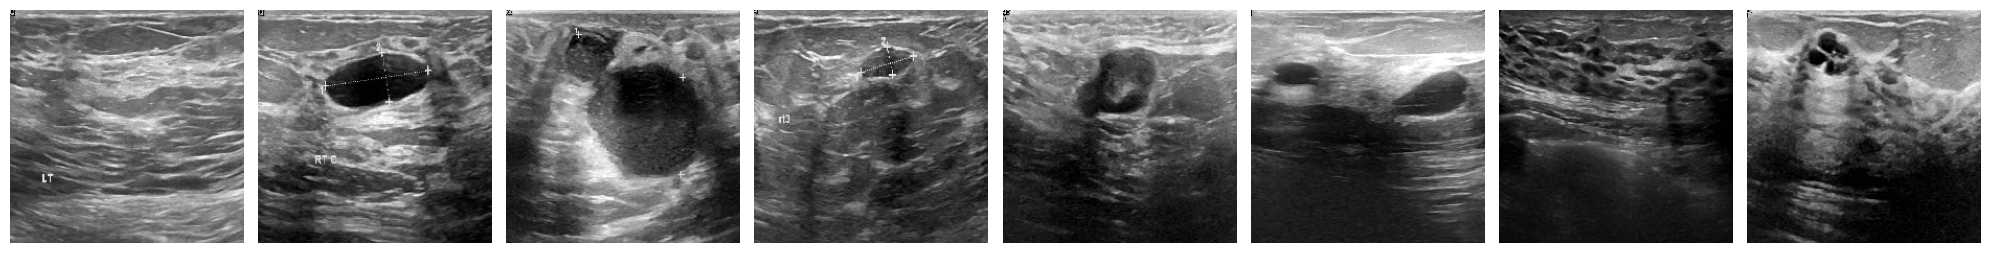

In [45]:
# Get a batch of images
x_batch, y_batch = next(test_generator)

# Define the number of images to show and set up the figure
num_images = 8
fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

# Plot the images
for i, ax in enumerate(axes):
    image = np.clip(x_batch[i] * 255, 0, 255).astype('uint8')
    ax.imshow(image.astype('uint8'), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [46]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())  # Extract class names

# Initialize a dictionary to hold the counts
class_counts = {class_name: 0 for class_name in class_names}

# Iterate over the classes array and count each class's occurrences
for class_index in train_generator.classes:
    class_name = class_names[class_index]
    class_counts[class_name] += 1

print(class_counts)

{'benign': 394, 'malignant': 361, 'normal': 320}


In [54]:
# MobileNet expects three channels
input_shape = (224, 224, 3)

input_image = Input(shape=(224, 224, 1))

# Lambda layer to replicate the grayscale channel
x = Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1))(input_image)

# MobileNet model, pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=x)

# Freeze the layers of the base model
base_model.trainable = True

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
# x = BatchNormalization()(x)
# x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.5)(x) 
x = Dense(3, activation='softmax')(x)

# Combine the base model and the custom layers into a final model
model = Model(inputs=input_image, outputs=x)

N = 27 
for layer in base_model.layers[:-N]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.legacy.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Show the summary of the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 lambda_4 (Lambda)           (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['lambda_4[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                        

/Users/erikamolnar/Anaconda/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [55]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
33/33 [==============================] - 13s 333ms/step - loss: 1.1322 - accuracy: 0.4276 - val_loss: 1.1711 - val_accuracy: 0.4531 - lr: 1.0000e-05
Epoch 2/50
33/33 [==============================] - 11s 318ms/step - loss: 0.9409 - accuracy: 0.5379 - val_loss: 1.0791 - val_accuracy: 0.4531 - lr: 1.0000e-05
Epoch 3/50
33/33 [==============================] - 11s 325ms/step - loss: 0.8099 - accuracy: 0.6376 - val_loss: 1.0559 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 4/50
33/33 [==============================] - 11s 323ms/step - loss: 0.7495 - accuracy: 0.6807 - val_loss: 1.0321 - val_accuracy: 0.4688 - lr: 1.0000e-05
Epoch 5/50
33/33 [==============================] - 10s 313ms/step - loss: 0.7084 - accuracy: 0.7085 - val_loss: 0.9683 - val_accuracy: 0.5469 - lr: 1.0000e-05
Epoch 6/50
33/33 [==============================] - 11s 322ms/step - loss: 0.6731 - accuracy: 0.7244 - val_loss: 1.0292 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 7/50
33/33 [======================

3/3 [==============================] - 1s 379ms/step - loss: 0.5114 - accuracy: 0.8125


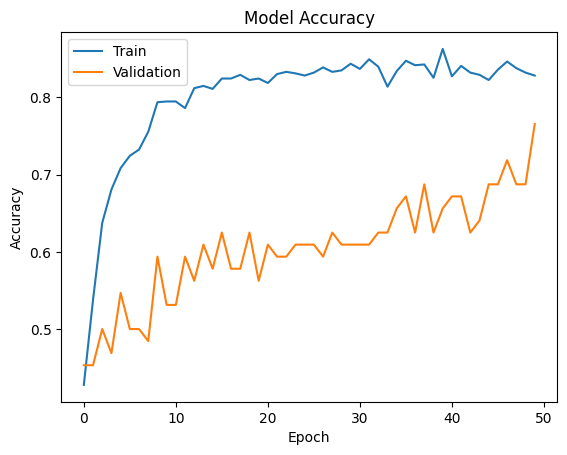

In [56]:
test_loss, test_acc = model.evaluate(test_generator)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [57]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

3/3 [==============================] - 1s 271ms/step


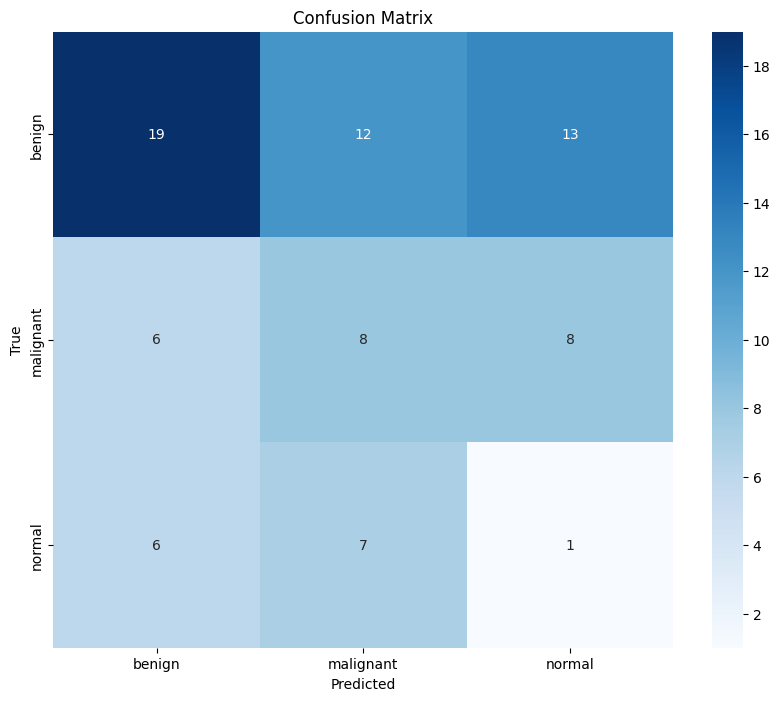

In [58]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [59]:
# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

      benign       0.61      0.43      0.51        44
   malignant       0.30      0.36      0.33        22
      normal       0.05      0.07      0.06        14

    accuracy                           0.35        80
   macro avg       0.32      0.29      0.30        80
weighted avg       0.43      0.35      0.38        80



In [60]:
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 35.00%


In [23]:

# Get the true classes from the generator
true_classes = test_generator.classes

class_indices = test_generator.class_indices

# Find misclassified indices where benign was predicted as normal
misclassified_indices = np.where(predicted_classes != true_classes)[0]
print(misclassified_indices)

# Retrieve the filenames of the misclassified benign images
misclassified_filenames = [test_generator.filenames[i] for i in misclassified_indices]

# Output the filenames of the misclassified benign images
for filename in misclassified_filenames:
    print(filename)

[ 0  1  3  6  9 10 13 14 18 19 20 21 22 24 25 28 33 35 36 38 39 40 43 44
 45 47 49 50 51 52 53 54 56 57 58 59 61 62 63 64 65 66 67 68 69 70 71 75
 76 79]
benign/benign (100).png
benign/benign (106).png
benign/benign (135).png
benign/benign (166).png
benign/benign (188).png
benign/benign (191).png
benign/benign (201).png
benign/benign (205).png
benign/benign (255).png
benign/benign (256).png
benign/benign (317).png
benign/benign (33).png
benign/benign (331).png
benign/benign (357).png
benign/benign (36).png
benign/benign (37).png
benign/benign (39).png
benign/benign (393).png
benign/benign (4).png
benign/benign (42).png
benign/benign (432).png
benign/benign (51).png
benign/benign (78).png
malignant/malignant (104).png
malignant/malignant (113).png
malignant/malignant (127).png
malignant/malignant (144).png
malignant/malignant (149).png
malignant/malignant (162).png
malignant/malignant (167).png
malignant/malignant (17).png
malignant/malignant (176).png
malignant/malignant (184).png
mali